### 航空公司客户价值分析  
#### 简介
>##### 现在越来越多的企业开始重视客户关系管理，其中的关键问题就是客户分类。区分不同价值的客户，实施个性化服务，才能实现企业的利润最大化。   
在开始项目之前，我想先说一些题外话，一般客户分类问题，多使用聚类方法（K-means）。什么是聚类呢？  
我可以举个简单的例子，移动公司希望把客户进行分类，假设设置分成三类，那么结果可能是（打电话最多的一类，用流量最多的一类，发短信最多的一类），但是当你用同样的程序训练分类器时，可能会变成（每个月费用最高的一类，中等的一类，最低的一类）。也就是说，训练出来的分类器带有一定的不确定性，如果你想要得到你想要的分类器，那一定要对原始数据相当了解，并提前做好处理。属性越多，这种不确定性可能会越大。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

data = pd.read_csv('data.csv', encoding = 'utf-8')
data.head(2)

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,ADD_Point_SUM,Eli_Add_Point_Sum,L1Y_ELi_Add_Points,Points_Sum,L1Y_Points_Sum,Ration_L1Y_Flight_Count,Ration_P1Y_Flight_Count,Ration_P1Y_BPS,Ration_L1Y_BPS,Point_NotFlight
0,54993,2006/11/02,2008/12/24,男,6,.,北京,CN,31.0,2014/03/31,...,39992,114452,111100,619760,370211,0.509524,0.490476,0.487221,0.512777,50
1,28065,2007/02/19,2007/08/03,男,6,NaN,北京,CN,42.0,2014/03/31,...,12000,53288,53288,415768,238410,0.514286,0.485714,0.489289,0.510708,33


In [2]:
data.columns

Index(['MEMBER_NO', 'FFP_DATE', 'FIRST_FLIGHT_DATE', 'GENDER', 'FFP_TIER',
       'WORK_CITY', 'WORK_PROVINCE', 'WORK_COUNTRY', 'AGE', 'LOAD_TIME',
       'FLIGHT_COUNT', 'BP_SUM', 'EP_SUM_YR_1', 'EP_SUM_YR_2', 'SUM_YR_1',
       'SUM_YR_2', 'SEG_KM_SUM', 'WEIGHTED_SEG_KM', 'LAST_FLIGHT_DATE',
       'AVG_FLIGHT_COUNT', 'AVG_BP_SUM', 'BEGIN_TO_FIRST', 'LAST_TO_END',
       'AVG_INTERVAL', 'MAX_INTERVAL', 'ADD_POINTS_SUM_YR_1',
       'ADD_POINTS_SUM_YR_2', 'EXCHANGE_COUNT', 'avg_discount',
       'P1Y_Flight_Count', 'L1Y_Flight_Count', 'P1Y_BP_SUM', 'L1Y_BP_SUM',
       'EP_SUM', 'ADD_Point_SUM', 'Eli_Add_Point_Sum', 'L1Y_ELi_Add_Points',
       'Points_Sum', 'L1Y_Points_Sum', 'Ration_L1Y_Flight_Count',
       'Ration_P1Y_Flight_Count', 'Ration_P1Y_BPS', 'Ration_L1Y_BPS',
       'Point_NotFlight'],
      dtype='object')

>##### 属性太多，我这里首先选出需要的属性，再清洗数据。  
飞行总次数F，总飞行公里数M，平均折扣率C,第二年飞行次数与第一年飞行次数的比例R。


In [3]:
df = data.loc[:,['FLIGHT_COUNT', 'SEG_KM_SUM','avg_discount']]
# 只保留第一年和第二年都有乘坐飞机的客户，删除的客户在这里不做分析。
df_f = data.query("P1Y_Flight_Count != 0 & L1Y_Flight_Count != 0")
# 把第二年飞行次数与第一年飞行次数的比例加入到df中，形成新列。
df['ratio'] = df_f['L1Y_Flight_Count'] / df_f['P1Y_Flight_Count']
# 删除有空值的行
df.dropna(axis=0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43894 entries, 0 to 62976
Data columns (total 4 columns):
FLIGHT_COUNT    43894 non-null int64
SEG_KM_SUM      43894 non-null int64
avg_discount    43894 non-null float64
ratio           43894 non-null float64
dtypes: float64(2), int64(2)
memory usage: 1.7 MB


>##### *注意：在真正的项目分析中，我们去掉一些属性简化分析是可以的，但是删除行，就会删掉一些客户，导致一些用户没有被分析到。所以最后单独存放你删除的这部分客户，另做分析。做企业的是不应该放弃任何一个客户的。*

#### 接下来需要对我们选出来数据继续特征缩放，可以对数据进行标准化处理，即采用公式：
>df = (df - df.mean(axis = 0)) / (df.std(axis = 0))  
#### 也可以极差比例  
>df = (df - df.min(axis = 0)) / (df.max(axis = 0) - df.min(axis = 0))

In [24]:
# 我这里采用了标准化处理，如果是极差的化，最后聚类的效果很不好。
df = (df - df.mean(axis = 0)) / (df.std(axis = 0))
# 表头重命名
df.columns = ['F','M','C','R']
df.head(2)

,F,M,C,R
0,12.585935,24.075672,1.324380,-0.284823
1,8.062647,11.711701,2.974238,-0.275097


>#### 以上所以准备工作做好后，下面我们就可以开始利用df数据集进行模型构建了。

### 构建K-Means聚类模型

In [25]:
from sklearn.cluster import KMeans
# 假设我需要聚类出5个不同类别的客户，创建分类器，并训练它。
km = KMeans(n_clusters =5, n_jobs = 4).fit(df)

# 聚类中心
print(km.cluster_centers_)
# 样本对应类别
km.labels_

[[-0.44909467 -0.41522175 -0.57574405 -0.13409275]
 [-0.37140613 -0.4045681   1.11250013 -0.19431178]
 [-0.04441323 -0.05864626 -0.12082992  3.61182709]
 [ 0.86265476  0.82881153  0.00369609 -0.16510764]
 [ 3.26282823  3.22643213  0.58988869 -0.14182281]]


array([4, 4, 4, ..., 1, 0, 0])

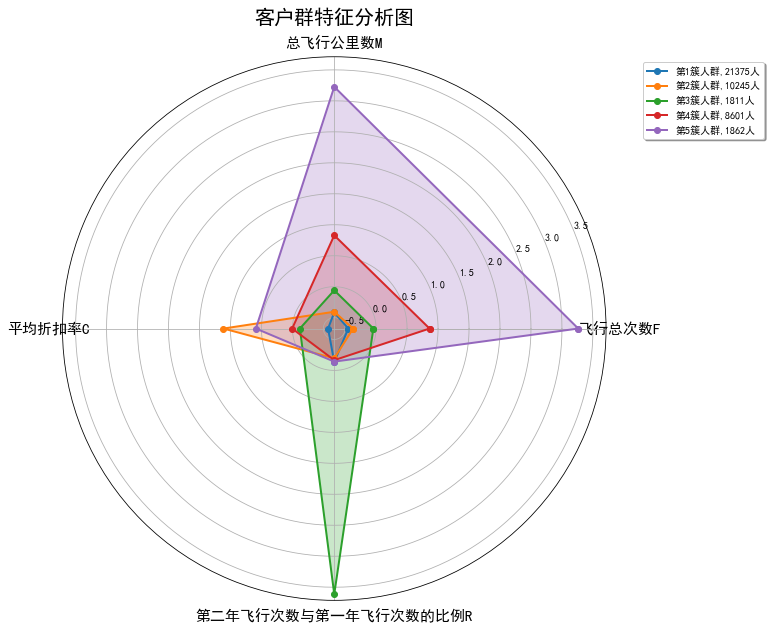

In [31]:
r1 = pd.Series(km.labels_).value_counts() #统计各个类别的数目
r2 = pd.DataFrame(km.cluster_centers_) #找出聚类中心
# 所有簇中心坐标值中最大值和最小值
max = r2.values.max()
min = r2.values.min()
r = pd.concat([r2, r1], axis = 1) #横向连接（0是纵向），得到聚类中心对应的类别下的数目
r.columns = list(df.columns) + [u'类别数目'] #重命名表头
 
# 绘图这里有一个网址可以参考他的作图https://blog.csdn.net/a857553315/article/details/79177524
fig=plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)
center_num = r.values
feature = ['飞行总次数F', '总飞行公里数M', '平均折扣率C', '第二年飞行次数与第一年飞行次数的比例R']
N =len(feature)
for i, v in enumerate(center_num):
    # 设置雷达图的角度，用于平分切开一个圆面
    angles=np.linspace(0, 2*np.pi, N, endpoint=False)
    # 为了使雷达图一圈封闭起来，需要下面的步骤
    center = np.concatenate((v[:-1],[v[0]]))
    angles = np.concatenate((angles,[angles[0]]))
    # 绘制折线图
    ax.plot(angles, center, 'o-', linewidth=2, label = "第%d簇人群,%d人"% (i+1,v[-1]))
    # 填充颜色
    ax.fill(angles, center, alpha=0.25)
    # 添加每个特征的标签
    ax.set_thetagrids(angles * 180/np.pi, feature, fontsize=15)
    # 设置雷达图的范围
    ax.set_ylim(min-0.1, max+0.1)
    # 添加标题
    plt.title('客户群特征分析图', fontsize=20)
    # 添加网格线
    ax.grid(True)
    # 设置图例
    plt.legend(loc='upper right', bbox_to_anchor=(1.3,1.0),ncol=1,fancybox=True,shadow=True)
    
# 显示图形
plt.show()

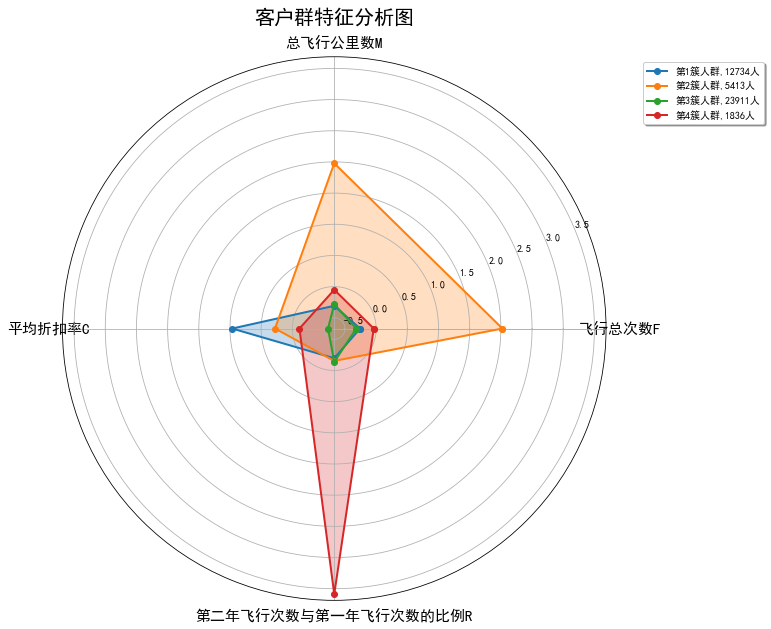

In [32]:
from sklearn.cluster import KMeans
# 假设我需要聚类出5个不同类别的客户，创建分类器，并训练它。
km = KMeans(n_clusters =4, n_jobs = 4).fit(df)

r1 = pd.Series(km.labels_).value_counts() #统计各个类别的数目
r2 = pd.DataFrame(km.cluster_centers_) #找出聚类中心
# 所有簇中心坐标值中最大值和最小值
max = r2.values.max()
min = r2.values.min()
r = pd.concat([r2, r1], axis = 1) #横向连接（0是纵向），得到聚类中心对应的类别下的数目
r.columns = list(df.columns) + [u'类别数目'] #重命名表头
 
# 绘图这里有一个网址可以参考他的作图https://blog.csdn.net/a857553315/article/details/79177524
fig=plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)
center_num = r.values
feature = ['飞行总次数F', '总飞行公里数M', '平均折扣率C', '第二年飞行次数与第一年飞行次数的比例R']
N =len(feature)
for i, v in enumerate(center_num):
    # 设置雷达图的角度，用于平分切开一个圆面
    angles=np.linspace(0, 2*np.pi, N, endpoint=False)
    # 为了使雷达图一圈封闭起来，需要下面的步骤
    center = np.concatenate((v[:-1],[v[0]]))
    angles = np.concatenate((angles,[angles[0]]))
    # 绘制折线图
    ax.plot(angles, center, 'o-', linewidth=2, label = "第%d簇人群,%d人"% (i+1,v[-1]))
    # 填充颜色
    ax.fill(angles, center, alpha=0.25)
    # 添加每个特征的标签
    ax.set_thetagrids(angles * 180/np.pi, feature, fontsize=15)
    # 设置雷达图的范围
    ax.set_ylim(min-0.1, max+0.1)
    # 添加标题
    plt.title('客户群特征分析图', fontsize=20)
    # 添加网格线
    ax.grid(True)
    # 设置图例
    plt.legend(loc='upper right', bbox_to_anchor=(1.3,1.0),ncol=1,fancybox=True,shadow=True)
    
# 显示图形
plt.show()

>#### 这里我尝试了修改n_clusters的值，发现还是聚类4种客户最好，这个你也可以试试，或者你也可以认为分5种客户效果更好。
>#### 从上面的图可以看出：
第1类客户：12734人，是平均折扣率较高的客户，这类客户可能比较关注折扣情况，推荐优惠政策可能会更吸引这一类客户。  
第2类客户：5413人，是总飞行公里数和次数较多的客户，这一类客户是我们应该重点保护的客户。  
第3类客户：23911人，各方面数据都很低，属于一般或低价值的客户。  
第4类客户：1826人，是乘坐次数比头一年有显著增加的客户，这一类客户潜力较大，可以再细分提供一些个性化服务。  

#### 第2类和第4类客户价值是较第1、3类客户价值大，这也暗合了市场的二八法则。
客户聚类这类问题非常常见，这种半监督学习算法由计算机承担了大部分工作。如果不深究算法，我们需要做的就是了解数据背景（熟悉业务），选择不同的数据，不同的思路最后得到的聚类结果也是不同的，这个在项目的开端我就有介绍。  
好了我的分析到这里就结束了，如果你有什么好的建议，欢迎联系我，我非常愿意同你分享。